In [1]:
import sklearn

In [2]:
import torch

In [3]:
from sklearn.datasets import make_circles
n_samples = 1000

X,y = make_circles(n_samples,
                   noise=0.03,
                  random_state=42)

In [4]:
len(X), len(y)

(1000, 1000)

In [5]:
print(f"First 5 smaples of x:\n {X[:5]}")
print(f"First 5 smaples of y:\n {y[:5]}")

First 5 smaples of x:
 [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First 5 smaples of y:
 [1 1 1 1 0]


In [6]:
import pandas as pd
circles = pd.DataFrame({"X1": X[:, 0],
                       "X2": X[:, 1],
                       "label": y})
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


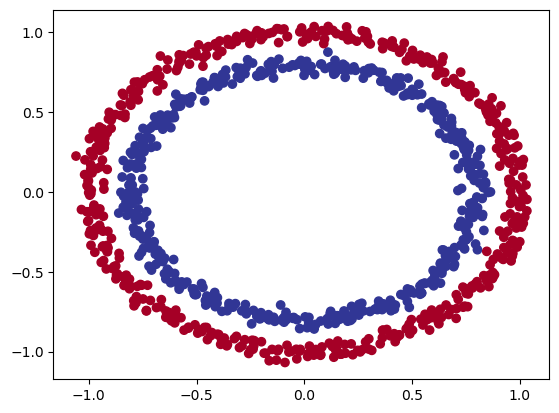

In [7]:
import matplotlib.pyplot as plt
plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c=y,
            cmap=plt.cm.RdYlBu);

In [8]:
X.shape, y.shape

((1000, 2), (1000,))

In [9]:
X

array([[ 0.75424625,  0.23148074],
       [-0.75615888,  0.15325888],
       [-0.81539193,  0.17328203],
       ...,
       [-0.13690036, -0.81001183],
       [ 0.67036156, -0.76750154],
       [ 0.28105665,  0.96382443]])

In [10]:
X_sample = X[0]
y_sample = y[0]

print(f"Values for one sample of X: {X_sample} and the same for y: {y_sample}")
print(f"shapes for one sample of X: {X_sample.shape} and same for y: {y_sample.shape} ")

Values for one sample of X: [0.75424625 0.23148074] and the same for y: 1
shapes for one sample of X: (2,) and same for y: () 


In [11]:
import numpy as np

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [12]:
X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                   y,
                                                   test_size=0.2,
                                                   random_state=42)

In [14]:
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

In [15]:
from torch import  nn
device = "cuda" if torch.cuda.is_available() else "cpu"

In [16]:
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=5)
        self.layer_2 = nn.Linear(in_features=5, out_features=1)

    def forward(self, x):
        return self.layer_2(self.layer_1(x))

model_0 = CircleModelV0().to(device)

In [17]:
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [18]:
device

'cuda'

In [19]:
next(model_0.parameters()).device

device(type='cuda', index=0)

In [20]:
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

In [21]:
model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [22]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[ 0.5902,  0.6445],
                      [ 0.4903, -0.6356],
                      [ 0.2835, -0.0112],
                      [ 0.4535,  0.3564],
                      [-0.6630, -0.5224]], device='cuda:0')),
             ('0.bias',
              tensor([ 0.3276, -0.3680,  0.3764,  0.5721,  0.4768], device='cuda:0')),
             ('1.weight',
              tensor([[-0.4011,  0.1386,  0.1348,  0.2521, -0.4340]], device='cuda:0')),
             ('1.bias', tensor([0.2204], device='cuda:0'))])

In [23]:
with torch.inference_mode():
    untrained_preds = model_0(X_test.to(device))
print(f"{len(untrained_preds)}{untrained_preds.shape}")
print(f"{len(X_test)} {X_test.shape}")
print(f"{untrained_preds[:10]}")
print(f"{y_test[:10]}")

200torch.Size([200, 1])
200 torch.Size([200, 2])
tensor([[-9.7283e-02],
        [ 2.0951e-05],
        [-1.5481e-01],
        [-8.1801e-02],
        [ 1.5877e-01],
        [ 2.1574e-01],
        [ 2.4119e-01],
        [ 2.9250e-01],
        [-1.6795e-01],
        [ 1.0010e-02]], device='cuda:0')
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


In [24]:
loss_fn = nn.BCEWithLogitsLoss()

In [25]:
optimizer = torch.optim.SGD(params=model_0.parameters(),
                           lr=0.1)

In [26]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc= (correct/len(y_pred))*100
    return acc

In [27]:
model_0.eval()
with torch.inference_mode():
    y_logits =  model_0(X_test.to(device))[:5]

y_logits

tensor([[-9.7283e-02],
        [ 2.0951e-05],
        [-1.5481e-01],
        [-8.1801e-02],
        [ 1.5877e-01]], device='cuda:0')

In [28]:
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.4757],
        [0.5000],
        [0.4614],
        [0.4796],
        [0.5396]], device='cuda:0')

In [29]:
y_preds = torch.round(y_pred_probs)

y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

y_preds.squeeze()

tensor([True, True, True, True, True], device='cuda:0')


tensor([0., 1., 0., 0., 1.], device='cuda:0')

In [30]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)


epochs = 1000
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range (epochs):
    model_0.train()
    y_logits = model_0(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))
    loss = loss_fn(y_logits,
                   y_train)
    acc = accuracy_fn(y_true=y_train,
                      y_pred=y_pred)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    model_0.eval()
    with torch.inference_mode():
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)
        if epoch % 100 ==0:
            print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:2f}% | Test loss: {test_loss:.5f} | Test acc : {test_acc:.2f}% ")

Epoch: 0 | Loss: 0.69663, Acc: 50.000000% | Test loss: 0.69889 | Test acc : 52.50% 
Epoch: 100 | Loss: 0.69329, Acc: 50.500000% | Test loss: 0.69447 | Test acc : 49.50% 
Epoch: 200 | Loss: 0.69301, Acc: 50.875000% | Test loss: 0.69447 | Test acc : 47.50% 
Epoch: 300 | Loss: 0.69298, Acc: 51.250000% | Test loss: 0.69459 | Test acc : 47.00% 
Epoch: 400 | Loss: 0.69298, Acc: 51.000000% | Test loss: 0.69465 | Test acc : 45.50% 
Epoch: 500 | Loss: 0.69298, Acc: 51.250000% | Test loss: 0.69467 | Test acc : 45.50% 
Epoch: 600 | Loss: 0.69298, Acc: 51.125000% | Test loss: 0.69468 | Test acc : 46.00% 
Epoch: 700 | Loss: 0.69298, Acc: 51.125000% | Test loss: 0.69468 | Test acc : 46.00% 
Epoch: 800 | Loss: 0.69298, Acc: 51.125000% | Test loss: 0.69468 | Test acc : 46.00% 
Epoch: 900 | Loss: 0.69298, Acc: 51.000000% | Test loss: 0.69468 | Test acc : 46.00% 


In [31]:
import requests
from pathlib import Path

if Path("helper_functions.py").is_file():
    print("exist")

else:
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("helper_functions.py", "wb") as f:
        f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

exist


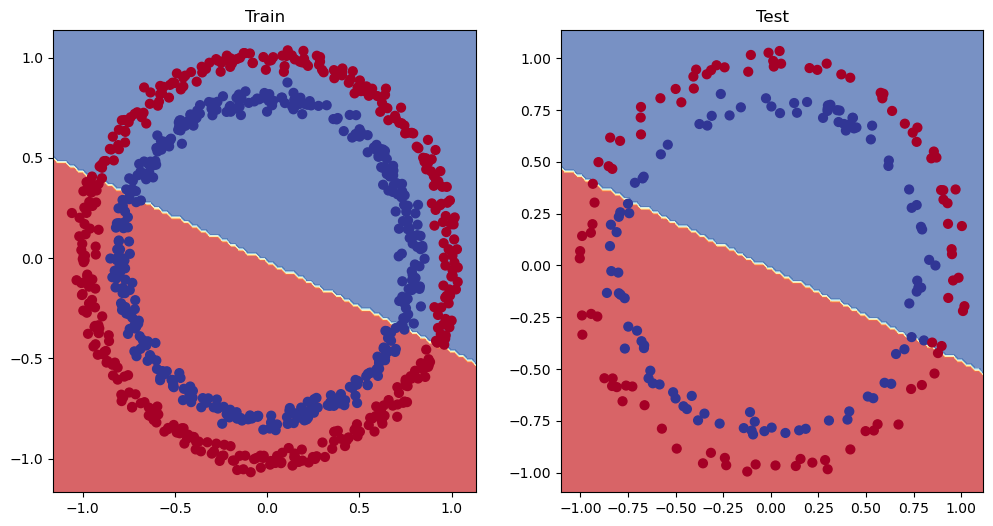

In [32]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

In [33]:
model_0.state_dict()


OrderedDict([('0.weight',
              tensor([[ 0.6711,  0.5904],
                      [ 0.4778, -0.6291],
                      [ 0.2641,  0.0010],
                      [ 0.4118,  0.3835],
                      [-0.5864, -0.5728]])),
             ('0.bias', tensor([ 0.3381, -0.3698,  0.3738,  0.5666,  0.4868])),
             ('1.weight',
              tensor([[-0.4505, -0.0211,  0.0738,  0.2032, -0.3968]])),
             ('1.bias', tensor([0.1959]))])

In [34]:
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features = 2, out_features = 10)
        self.layer_2 = nn.Linear(in_features = 10, out_features = 10)
        self.layer_3 = nn.Linear(in_features = 10, out_features = 1)

    def forward(self, x):
    
        return self.layer_3(self.layer_2(self.layer_1(x)))

model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [35]:
loss_fm = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(params=model_1.parameters(),
                           lr=0.1)

In [36]:
torch.manual_seed(42)

torch.cuda.manual_seed(42)

epochs = 1000

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    model_1.train()
    y_logits = model_1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train,
                     y_pred=y_pred)
    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    model_1.eval()
    with torch.inference_mode():
        test_logits = model_1(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        test_loss = loss_fn(test_logits,
                           y_test)
        test_acc = accuracy_fn(y_true=y_test,
                              y_pred=test_pred)

    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss: .5f} | Acc : {acc:.2f}  | Test_loss: {test_loss:.5f}, Test_acc {test_acc:.2f}%  ")

Epoch: 0 | Loss:  0.69396 | Acc : 50.88  | Test_loss: 0.69261, Test_acc 51.00%  
Epoch: 100 | Loss:  0.69305 | Acc : 50.38  | Test_loss: 0.69379, Test_acc 48.00%  
Epoch: 200 | Loss:  0.69299 | Acc : 51.12  | Test_loss: 0.69437, Test_acc 46.00%  
Epoch: 300 | Loss:  0.69298 | Acc : 51.62  | Test_loss: 0.69458, Test_acc 45.00%  
Epoch: 400 | Loss:  0.69298 | Acc : 51.12  | Test_loss: 0.69465, Test_acc 46.00%  
Epoch: 500 | Loss:  0.69298 | Acc : 51.00  | Test_loss: 0.69467, Test_acc 46.00%  
Epoch: 600 | Loss:  0.69298 | Acc : 51.00  | Test_loss: 0.69468, Test_acc 46.00%  
Epoch: 700 | Loss:  0.69298 | Acc : 51.00  | Test_loss: 0.69468, Test_acc 46.00%  
Epoch: 800 | Loss:  0.69298 | Acc : 51.00  | Test_loss: 0.69468, Test_acc 46.00%  
Epoch: 900 | Loss:  0.69298 | Acc : 51.00  | Test_loss: 0.69468, Test_acc 46.00%  


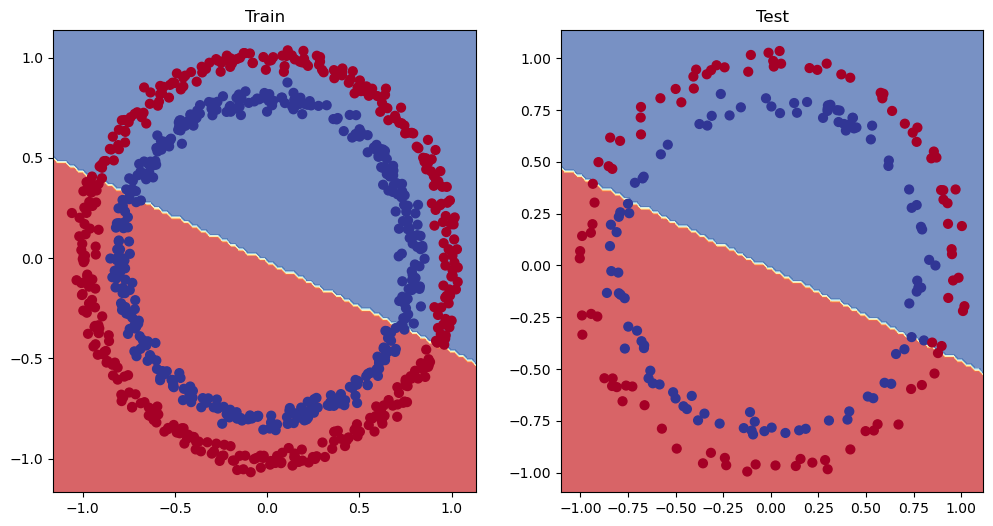

In [37]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

In [38]:
weight = 0.7
bias = 0.3

start = 0
end = 1
step = 0.01



X_regression = torch.arange(start, end, step).unsqueeze(dim=1)
y_regression = weight*X_regression + bias

print(len(X_regression))
X_regression[:5], y_regression[:5]

100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [39]:
train_split = int(0.8* len(X_regression))
X_train_regression, y_train_regression = X_regression[:train_split], y_regression[:train_split]
X_test_regression, y_test_regression= X_regression[train_split:], y_regression[train_split:]

len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

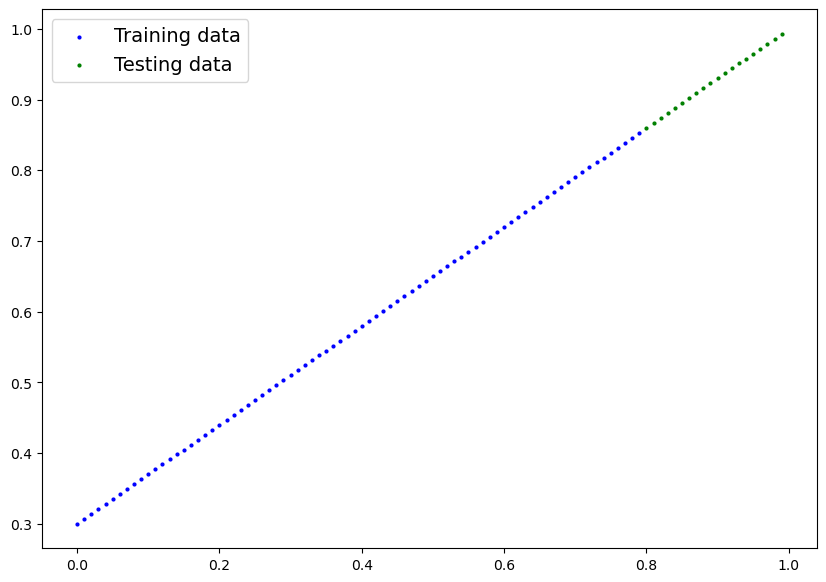

In [40]:
plot_predictions(train_data=X_train_regression,
                 train_labels=y_train_regression,
                 test_data=X_test_regression,
                 test_labels=y_test_regression,
                predictions=None);

In [41]:
CircleModelV1()

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [42]:
model_2 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1)
).to(device)

model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [43]:
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params=model_2.parameters(),
                           lr=0.01)

In [44]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)


epochs = 1000

X_train_regression, y_train_regression = X_train_regression.to(device), y_train_regression.to(device)
X_test_regression, y_test_regression = X_test_regression.to(device), y_test_regression.to(device)

for epoch in range(epochs):
    y_pred = model_2(X_train_regression)
    loss = loss_fn(y_pred, y_train_regression)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model_2.eval()
    with torch.inference_mode():
        test_pred = model_2(X_test_regression)
        test_loss = loss_fn(test_pred, y_test_regression)

    if epoch % 100 == 0: 
        print(f"epoch: {epoch}  | loss: {loss:.5f}  | test_loss: {test_loss:.5f} ")

epoch: 0  | loss: 0.57896  | test_loss: 0.82273 
epoch: 100  | loss: 0.03496  | test_loss: 0.00156 
epoch: 200  | loss: 0.03268  | test_loss: 0.00330 
epoch: 300  | loss: 0.02942  | test_loss: 0.00446 
epoch: 400  | loss: 0.02731  | test_loss: 0.00570 
epoch: 500  | loss: 0.02672  | test_loss: 0.00534 
epoch: 600  | loss: 0.02627  | test_loss: 0.00511 
epoch: 700  | loss: 0.02594  | test_loss: 0.00496 
epoch: 800  | loss: 0.02482  | test_loss: 0.00394 
epoch: 900  | loss: 0.02333  | test_loss: 0.00462 


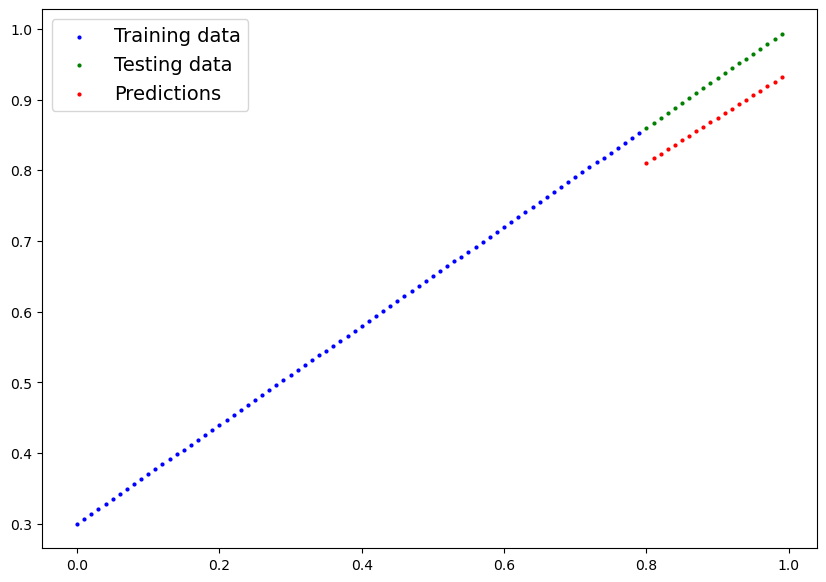

In [45]:
model_2.eval()

with torch.inference_mode():
    y_preds = model_2(X_test_regression)

plot_predictions(train_data=X_train_regression.cpu(),
                train_labels=y_train_regression.cpu(),
                test_data=X_test_regression.cpu(),
                test_labels=y_test_regression.cpu(),
                predictions=y_preds.cpu());

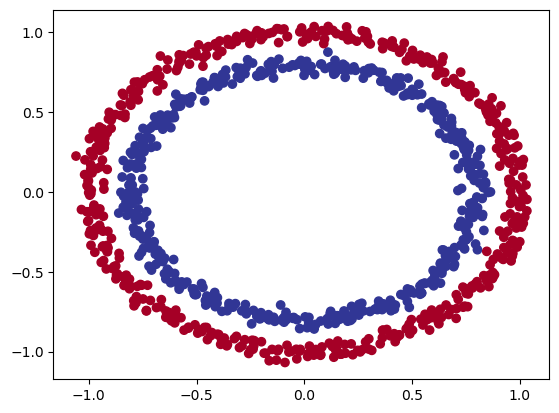

In [46]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples,
                   noise=0.03,
                   random_state=42)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu);


In [47]:
import torch
from sklearn.model_selection import train_test_split

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X_train, X_test, y_train, y_test = train_test_split(X,
                                                   y,
                                                   test_size=0.2,
                                                   random_state=42)
X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

In [48]:
from torch import nn
class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features = 2, out_features=10)
        self.layer_2 = nn.Linear(in_features = 10, out_features=10)
        self.layer_3= nn.Linear(in_features = 10, out_features = 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_3 = CircleModelV2().to(device)
model_3

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [49]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_3.parameters(),
                           lr=0.1)


In [50]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

epochs = 10000

for epoch in range(epochs):
    model_3.train()

    y_logits = model_3(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train,
                     y_pred=y_pred)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    model_3.eval()
    with torch.inference_mode():
        test_logits = model_3(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true = y_test,
                              y_pred = test_pred)

    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.4f} | Acc : {acc:.2f}%  | Test_loss: {test_loss:.4f}, Test_acc {test_acc:.2f}%  ")

Epoch: 0 | Loss: 0.6929 | Acc : 50.00%  | Test_loss: 0.6932, Test_acc 50.00%  
Epoch: 100 | Loss: 0.6912 | Acc : 52.88%  | Test_loss: 0.6910, Test_acc 52.50%  
Epoch: 200 | Loss: 0.6898 | Acc : 53.37%  | Test_loss: 0.6894, Test_acc 55.00%  
Epoch: 300 | Loss: 0.6879 | Acc : 53.00%  | Test_loss: 0.6872, Test_acc 56.00%  
Epoch: 400 | Loss: 0.6852 | Acc : 52.75%  | Test_loss: 0.6841, Test_acc 56.50%  
Epoch: 500 | Loss: 0.6810 | Acc : 52.75%  | Test_loss: 0.6794, Test_acc 56.50%  
Epoch: 600 | Loss: 0.6751 | Acc : 54.50%  | Test_loss: 0.6729, Test_acc 56.00%  
Epoch: 700 | Loss: 0.6666 | Acc : 58.38%  | Test_loss: 0.6632, Test_acc 59.00%  
Epoch: 800 | Loss: 0.6516 | Acc : 64.00%  | Test_loss: 0.6476, Test_acc 67.50%  
Epoch: 900 | Loss: 0.6236 | Acc : 74.00%  | Test_loss: 0.6215, Test_acc 79.00%  
Epoch: 1000 | Loss: 0.5682 | Acc : 87.75%  | Test_loss: 0.5738, Test_acc 86.50%  
Epoch: 1100 | Loss: 0.4815 | Acc : 93.50%  | Test_loss: 0.4993, Test_acc 90.50%  
Epoch: 1200 | Loss: 0.3706 |

In [51]:
model_3.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[ 0.9036,  1.5960],
                      [-0.7052,  2.7153],
                      [-0.1549,  0.1427],
                      [-3.0099, -0.3671],
                      [ 0.8623, -2.9784],
                      [ 1.7082, -0.0545],
                      [ 2.3630,  0.5450],
                      [ 0.3410, -0.0998],
                      [ 0.5872,  0.8907],
                      [-0.3301,  0.1802]], device='cuda:0')),
             ('layer_1.bias',
              tensor([-0.2418, -1.2439, -0.2872, -0.6927, -0.7581, -0.8380, -0.9570, -0.4252,
                      -0.1943, -0.6984], device='cuda:0')),
             ('layer_2.weight',
              tensor([[-0.0179, -0.9311,  0.2441, -0.4759, -0.5108, -0.1861, -0.4244,  0.2555,
                       -0.0917, -0.0997],
                      [ 1.6224,  2.6898,  0.1331,  2.8227,  2.7405,  1.5594,  2.2915,  0.0566,
                        0.9245, -0.1927],
                      [-0.3130, -0.124

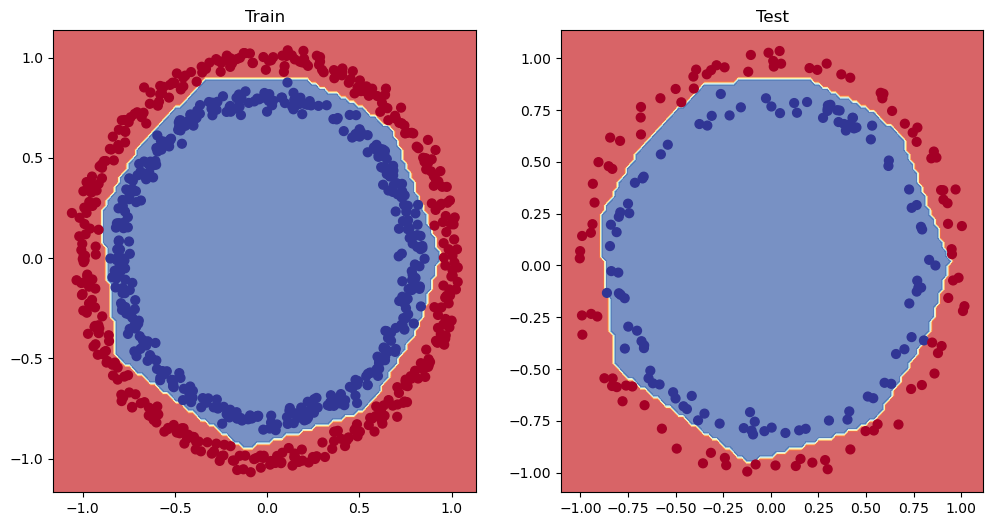

In [52]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_3, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test)

In [53]:
A = torch.arange(-10, 10, 1, dtype=torch.float32)
A

tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
          2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.])

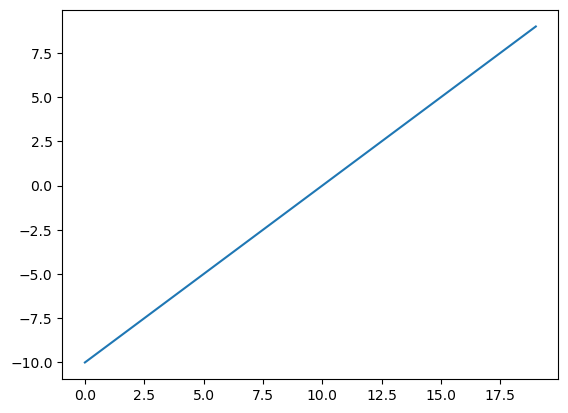

In [54]:
plt.plot(A);

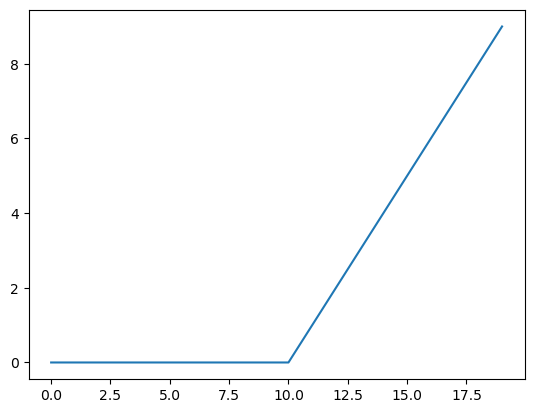

In [55]:
plt.plot(torch.relu(A));

In [56]:
def relu(x: torch.Tensor) -> torch.Tensor:
    return torch.maximum(torch.tensor(0), x)

In [57]:
relu(A)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

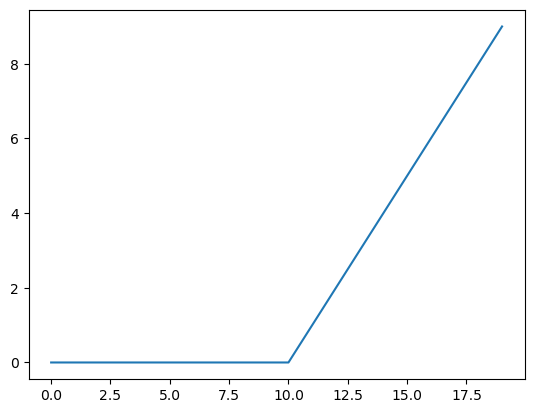

In [58]:
plt.plot(relu(A));

In [59]:
def sigmoid(x):
    return 1/ (1+ torch.exp(-x))

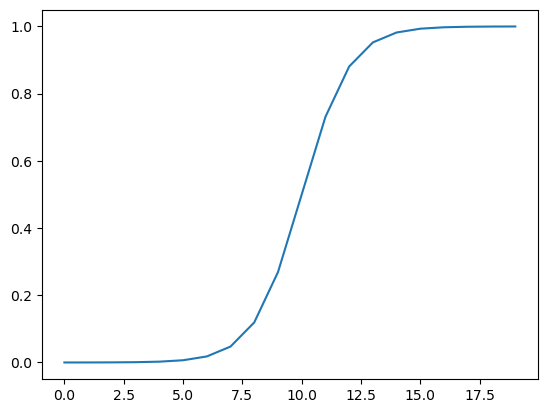

In [60]:
plt.plot(sigmoid(A));

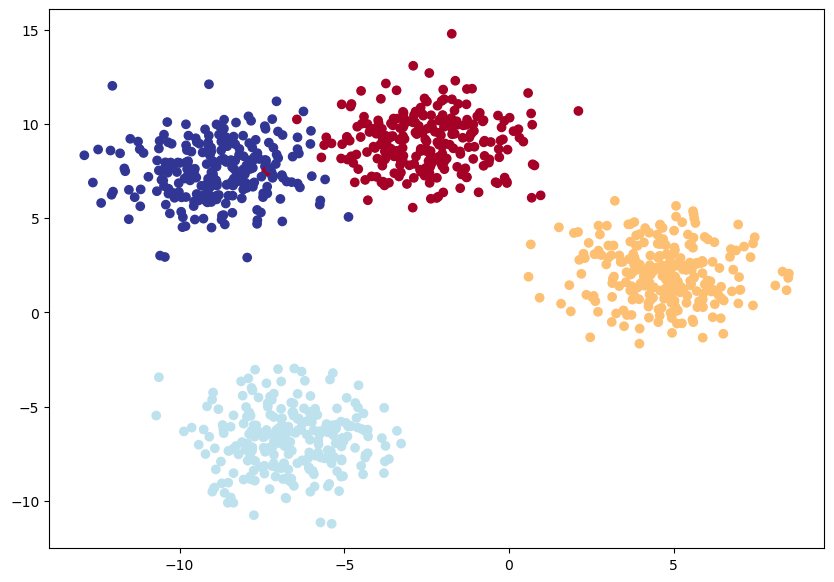

In [121]:
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split


NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

X_blob, y_blob = make_blobs(n_samples=1000,
                           n_features=NUM_FEATURES,
                           centers=NUM_CLASSES,
                           cluster_std=1.5,
                           random_state=RANDOM_SEED)
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)


X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
                                                                        y_blob,
                                                                        test_size=0.2,
                                                                        random_state=RANDOM_SEED)

plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c = y_blob, cmap=plt.cm.RdYlBu)

In [122]:
device = "cuda" if torch.cuda.is_available() else "cpu"

device

'cuda'

In [157]:
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        """
        Args:
            input_features(int)
            output_features(int)
            hidden_unit(int)
        Returns :
        Example:
        """
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_features),
        )

    def forward(self, x):
        return self.linear_layer_stack(x)

model_4 = BlobModel(input_features=2,
                   output_features=4,
                   hidden_units=8).to(device)
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [158]:
X_blob_train.shape, y_blob_train[:5]

(torch.Size([800, 2]), tensor([1, 0, 2, 2, 0], device='cuda:0'))

In [159]:
torch.unique(y_blob_train)

tensor([0, 1, 2, 3], device='cuda:0')

In [160]:
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(params=model_4.parameters(),
                           lr=0.1)

In [161]:
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_blob_test.to(device))

y_logits[:10]

tensor([[-0.7646, -0.7412, -1.5777, -1.1376],
        [-0.0973, -0.9431, -0.5963, -0.1371],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [-0.4134, -0.5204, -0.9303, -0.6963],
        [-0.3118, -1.3736, -1.1991, -0.3834],
        [-0.1497, -1.0617, -0.7107, -0.1645],
        [ 0.1539, -0.2887,  0.1520, -0.0109],
        [-0.2154, -1.1795, -0.9300, -0.2745],
        [ 0.2443, -0.2472,  0.1649,  0.0061],
        [-0.2329, -1.2120, -0.9849, -0.3004]], device='cuda:0')

In [162]:
y_pred_probs = torch.softmax(y_logits, dim=1)
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[-0.7646, -0.7412, -1.5777, -1.1376],
        [-0.0973, -0.9431, -0.5963, -0.1371],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [-0.4134, -0.5204, -0.9303, -0.6963],
        [-0.3118, -1.3736, -1.1991, -0.3834]], device='cuda:0')
tensor([[0.3169, 0.3244, 0.1405, 0.2182],
        [0.3336, 0.1432, 0.2026, 0.3206],
        [0.3011, 0.1843, 0.2823, 0.2323],
        [0.3078, 0.2766, 0.1836, 0.2320],
        [0.3719, 0.1286, 0.1532, 0.3463]], device='cuda:0')


In [163]:
y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds

tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 3, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 1, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 3, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 1, 0, 1], device='cuda:0')

In [164]:
y_blob_test

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0, 0, 1, 0, 0, 0, 3, 3, 2, 3, 3, 3, 0, 1, 2,
        2, 2, 3, 0, 1, 0, 3, 1, 1, 3, 1, 2, 1, 3, 0, 2, 0, 3, 3, 2, 0, 3, 1, 1,
        0, 3, 1, 0, 1, 1, 3, 2, 1, 1, 3, 2, 2, 0, 3, 2, 2, 0, 0, 3, 3, 0, 0, 3,
        3, 3, 2, 3, 3, 3, 3, 1, 0, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 1, 3, 3, 3,
        1, 0, 3, 2, 0, 0, 3, 0, 2, 3, 1, 0, 3, 2, 1, 1, 0, 2, 2, 3, 0, 0, 1, 2,
        2, 3, 0, 1, 2, 0, 0, 0, 2, 3, 1, 2, 3, 2, 0, 3, 0, 0, 1, 1, 1, 0, 2, 2,
        2, 2, 0, 3, 3, 2, 2, 1, 3, 2, 0, 0, 3, 3, 2, 1, 2, 0, 3, 2, 0, 3, 2, 0,
        2, 2, 2, 0, 3, 1, 1, 1, 1, 1, 3, 1, 0, 2, 2, 1, 2, 2, 0, 1, 2, 2, 0, 0,
        1, 3, 2, 0, 3, 1, 2, 1], device='cuda:0')

In [165]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 100

X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epochs):
    model_4.train()

    y_logits = model_4(X_blob_train)
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

    loss = loss_fn(y_logits, y_blob_train)
    acc = accuracy_fn(y_true=y_blob_train,
                     y_pred=y_pred)
    optimizer.zero_grad()
    loss.backward()

    optimizer.step()

    model_4.eval()
    with torch.inference_mode():
        test_logits = model_4(X_blob_test)
        test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)

        test_loss = loss_fn(test_logits, y_blob_test)
        test_acc = accuracy_fn(y_true=y_blob_test,
                              y_pred=test_pred)
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.4f} | Acc:  {acc:.2f}% | Test_Loss: {test_loss:4f}  | Test_Acc: {test_acc:.2f}% ")

Epoch: 0 | Loss: 1.1588 | Acc:  40.38% | Test_Loss: 1.075542  | Test_Acc: 23.00% 
Epoch: 10 | Loss: 0.6448 | Acc:  96.75% | Test_Loss: 0.660687  | Test_Acc: 23.00% 
Epoch: 20 | Loss: 0.4254 | Acc:  98.50% | Test_Loss: 0.430741  | Test_Acc: 23.00% 
Epoch: 30 | Loss: 0.2529 | Acc:  99.12% | Test_Loss: 0.245076  | Test_Acc: 23.00% 
Epoch: 40 | Loss: 0.1123 | Acc:  99.25% | Test_Loss: 0.102285  | Test_Acc: 23.00% 
Epoch: 50 | Loss: 0.0663 | Acc:  99.25% | Test_Loss: 0.058475  | Test_Acc: 23.00% 
Epoch: 60 | Loss: 0.0507 | Acc:  99.25% | Test_Loss: 0.042932  | Test_Acc: 23.00% 
Epoch: 70 | Loss: 0.0430 | Acc:  99.25% | Test_Loss: 0.034910  | Test_Acc: 23.00% 
Epoch: 80 | Loss: 0.0384 | Acc:  99.25% | Test_Loss: 0.029878  | Test_Acc: 23.00% 
Epoch: 90 | Loss: 0.0352 | Acc:  99.25% | Test_Loss: 0.026627  | Test_Acc: 23.00% 


In [166]:
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_blob_test)

y_logits[:10]

tensor([[-0.6249,  5.9860, -7.6323, -8.4470],
        [-2.1738, -6.3750, -3.7202,  3.1203],
        [-3.4102, -3.8958,  3.1567, -2.6119],
        [-1.1505,  4.1962, -3.8472, -4.8820],
        [ 3.7548, -1.3391, -9.1422, -6.9466],
        [-2.8211, -7.5767, -4.2944,  3.7944],
        [-3.0306, -3.3328,  2.7955, -2.1374],
        [ 3.3761, -4.0375, -6.8987, -3.5503],
        [-4.3620, -4.9904,  3.8123, -3.3814],
        [ 3.5012, -3.0281, -7.5401, -4.7064]], device='cuda:0')

In [167]:
y_pred_probs =  torch.softmax(y_logits, dim=1)
y_pred_probs[:10]

tensor([[1.3438e-03, 9.9865e-01, 1.2164e-06, 5.3854e-07],
        [4.9905e-03, 7.4740e-05, 1.0630e-03, 9.9387e-01],
        [1.3985e-03, 8.6060e-04, 9.9463e-01, 3.1073e-03],
        [4.7389e-03, 9.9483e-01, 3.1956e-04, 1.1353e-04],
        [9.9388e-01, 6.0966e-03, 2.4904e-06, 2.2378e-05],
        [1.3372e-03, 1.1504e-05, 3.0644e-04, 9.9834e-01],
        [2.9138e-03, 2.1537e-03, 9.8781e-01, 7.1181e-03],
        [9.9838e-01, 6.0198e-04, 3.4435e-05, 9.7989e-04],
        [2.8147e-04, 1.5016e-04, 9.9882e-01, 7.5044e-04],
        [9.9825e-01, 1.4575e-03, 1.5998e-05, 2.7210e-04]], device='cuda:0')

In [168]:
y_blob_test

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0, 0, 1, 0, 0, 0, 3, 3, 2, 3, 3, 3, 0, 1, 2,
        2, 2, 3, 0, 1, 0, 3, 1, 1, 3, 1, 2, 1, 3, 0, 2, 0, 3, 3, 2, 0, 3, 1, 1,
        0, 3, 1, 0, 1, 1, 3, 2, 1, 1, 3, 2, 2, 0, 3, 2, 2, 0, 0, 3, 3, 0, 0, 3,
        3, 3, 2, 3, 3, 3, 3, 1, 0, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 1, 3, 3, 3,
        1, 0, 3, 2, 0, 0, 3, 0, 2, 3, 1, 0, 3, 2, 1, 1, 0, 2, 2, 3, 0, 0, 1, 2,
        2, 3, 0, 1, 2, 0, 0, 0, 2, 3, 1, 2, 3, 2, 0, 3, 0, 0, 1, 1, 1, 0, 2, 2,
        2, 2, 0, 3, 3, 2, 2, 1, 3, 2, 0, 0, 3, 3, 2, 1, 2, 0, 3, 2, 0, 3, 2, 0,
        2, 2, 2, 0, 3, 1, 1, 1, 1, 1, 3, 1, 0, 2, 2, 1, 2, 2, 0, 1, 2, 2, 0, 0,
        1, 3, 2, 0, 3, 1, 2, 1], device='cuda:0')

In [169]:
y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds[:10]

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')

In [170]:
y_blob_test

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0, 0, 1, 0, 0, 0, 3, 3, 2, 3, 3, 3, 0, 1, 2,
        2, 2, 3, 0, 1, 0, 3, 1, 1, 3, 1, 2, 1, 3, 0, 2, 0, 3, 3, 2, 0, 3, 1, 1,
        0, 3, 1, 0, 1, 1, 3, 2, 1, 1, 3, 2, 2, 0, 3, 2, 2, 0, 0, 3, 3, 0, 0, 3,
        3, 3, 2, 3, 3, 3, 3, 1, 0, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 1, 3, 3, 3,
        1, 0, 3, 2, 0, 0, 3, 0, 2, 3, 1, 0, 3, 2, 1, 1, 0, 2, 2, 3, 0, 0, 1, 2,
        2, 3, 0, 1, 2, 0, 0, 0, 2, 3, 1, 2, 3, 2, 0, 3, 0, 0, 1, 1, 1, 0, 2, 2,
        2, 2, 0, 3, 3, 2, 2, 1, 3, 2, 0, 0, 3, 3, 2, 1, 2, 0, 3, 2, 0, 3, 2, 0,
        2, 2, 2, 0, 3, 1, 1, 1, 1, 1, 3, 1, 0, 2, 2, 1, 2, 2, 0, 1, 2, 2, 0, 0,
        1, 3, 2, 0, 3, 1, 2, 1], device='cuda:0')

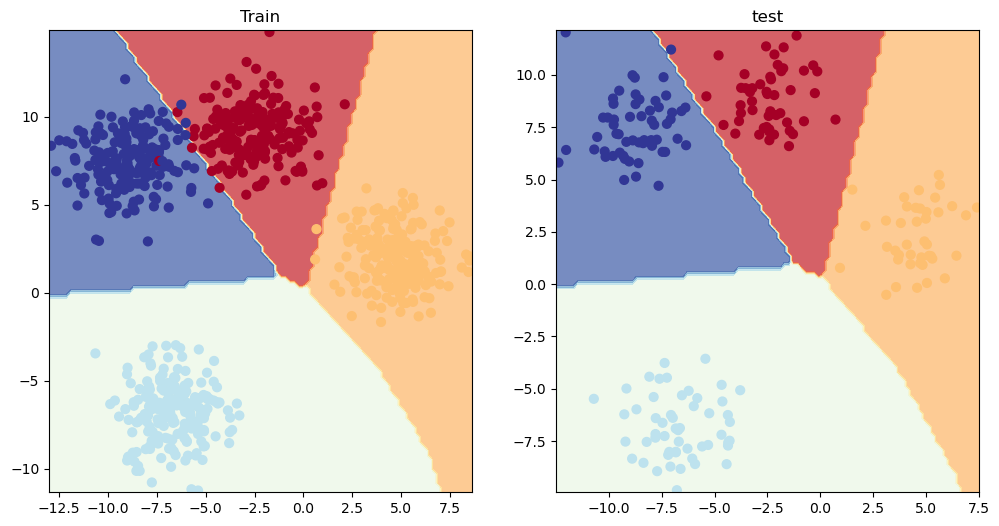

In [171]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1,2,2)
plt.title("test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)

In [173]:
!pip install torchmetrics

   ---------------------------------------- 0.0/841.5 kB ? eta -:--:--
   - ------------------------------------- 41.0/841.5 kB 960.0 kB/s eta 0:00:01
   --------- ------------------------------ 194.6/841.5 kB 2.4 MB/s eta 0:00:01
   ----------------- ---------------------- 358.4/841.5 kB 2.8 MB/s eta 0:00:01
   ------------------------------ --------- 645.1/841.5 kB 4.0 MB/s eta 0:00:01
   ---------------------------------------- 841.5/841.5 kB 4.1 MB/s eta 0:00:00


In [181]:
from torchmetrics import Accuracy

torchmetric_accuracy = Accuracy(task="multiclass", num_classes=4).to(device)

torchmetric_accuracy(y_preds, y_blob_test)

tensor(0.9950, device='cuda:0')